In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
from scipy import interpolate


with open('./app/rfr_model_bag.pkl','rb') as p:
    bag = pickle.load(p)

c:\Users\SwanS\Anaconda3\envs\grs_fit\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
bag.keys()

dict_keys(['df', 'grs_model', 'grs_parameters', 'gcs_model', 'gcs_parameters'])

In [3]:
df = bag['df'].sort_values(by=['DIRECT_COST'])
grs_model = bag['grs_model']
grs_parameters = bag['grs_parameters']
gcs_model = bag['gcs_model']
gcs_parameters = bag['gcs_parameters']

In [106]:
df = df[df['DIRECT_COST'] > 0] #.drop_duplicates(subset=['DIRECT_COST'])

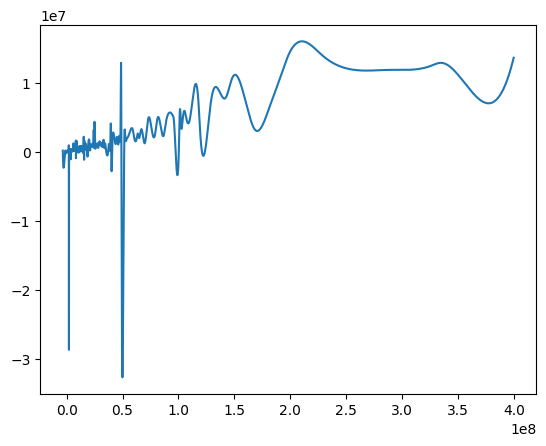

In [4]:
df_curve = df.drop_duplicates(subset=['DIRECT_COST'])
x_curve = df_curve.DIRECT_COST.to_list()
y_curve = df_curve.GRS_PREDICTIONS.to_list()
spl = interpolate.splrep(x_curve,y_curve)

x_curve = np.linspace(min(x_curve), max(x_curve), len(x_curve))
y_curve = interpolate.splev(x_curve, spl)

plt.plot(x_curve, y_curve)

In [5]:
def ModelAndScatterPlot(df_data, target_name, graphWidth, graphHeight, job_name, input_X):

    # set some varibles for use throughout
    feature_name = 'DIRECT COST'
    predictions_name = 'GRS PREDICTIONS'
    xData = np.array(df_data['DIRECT_COST'])
    yData = np.array(df_data[f'{target_name}_TRUE'])
    yPred = np.array(df_data[f'{target_name}_PREDICTIONS'])

    absError = yPred - yData
    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(yData))

    # pare down df for vis
    over_val = [_ for _ in df_data.DIRECT_COST.to_list() if _ > input_X[0]]
    over_val = sorted(over_val, reverse=True)
    under_val = [_ for _ in df_data.DIRECT_COST.to_list() if _ < input_X[0]]
    under_val = sorted(under_val, reverse=True)
    val_range = over_val[:20] + under_val[:20]
    df_working = df_data.loc[df_data['DIRECT_COST'].isin(val_range)]
    xData = np.array(df_working['DIRECT_COST'])
    yData = np.array(df_working[f'{target_name}_TRUE'])
    yPred = np.array(df_working[f'{target_name}_PREDICTIONS'])

    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'o', alpha=0.3, label='actual data')

    # now mak the predictions curve
    df_curve = df_working.drop_duplicates(subset=['DIRECT_COST'])
    x_curve = df_curve.DIRECT_COST.to_list()
    y_curve = df_curve[f'{target_name}_PREDICTIONS'].to_list()
    spl = interpolate.splrep(x_curve,y_curve)

    x_curve = np.linspace(min(x_curve), max(x_curve), len(x_curve))
    y_curve = interpolate.splev(x_curve, spl)

    # now the upper bound
    axes.plot(x_curve, y_curve + RMSE, c='b', alpha=0.5, linestyle='--', linewidth=0.7, label=f'{target_name} + σ')

    # now the model as a line plot
    axes.plot(x_curve, y_curve, c='g', linewidth=1, label=f'{target_name} ml model')

    # now the lower bound
    axes.plot(x_curve, y_curve - RMSE, c='r', alpha=0.5, linestyle='--', linewidth=0.7, label=f'{target_name} - σ')

    # color +/- 1 std devialtion
    axes.fill_between(x_curve, y_curve + RMSE, y_curve - RMSE, alpha=0.15)

    # now a test value
    prediction = grs_model.predict([input_X])
    j, k = input_X[0], prediction
    plt.text(0.1, 0.8, f'{job_name}: {feature_name} = ${j:,.0f}',ha='left',va='top', weight='bold',transform = axes.transAxes)
    axes.scatter(j, k+RMSE, c='b', marker='D', label=f'{job_name}, {target_name} + σ')
    axes.annotate(f'{target_name} + σ = ${int(prediction)+RMSE:,.0f}', xy=(j, k+RMSE), xytext=(20,10), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))
    axes.scatter(j, k, c='g', marker='D', label=f'{job_name} Predicted {target_name}')
    axes.annotate(f'Predicted {target_name} = ${int(prediction):,.0f}', (j, k), xytext=(40,0), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))
    axes.scatter(j, k-RMSE, c='r', marker='D', label=f'{job_name}, {target_name} - σ')
    axes.annotate(f'{target_name} - σ = ${int(prediction)-RMSE:,.0f}', (j, k-RMSE), xytext=(20,-10), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))

    # labels and stuff
    axes.set_xlabel(feature_name)
    axes.set_ylabel(target_name)
    fmt = '${x:,.0f}'
    tick = StrMethodFormatter(fmt)
    axes.xaxis.set_major_formatter(tick)
    axes.yaxis.set_major_formatter(tick)
    axes.legend(loc='best')

    details = f'{job_name}: {feature_name} = ${input_X[0]:,.0f}, Predicted {target_name}: ${int(prediction):,.0f}\n'+\
                        f'RMSE: {RMSE}\n'+\
                        f'R-squared: {Rsquared}'
    
    return f, details, prediction

c:\Users\SwanS\Anaconda3\envs\grs_fit\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


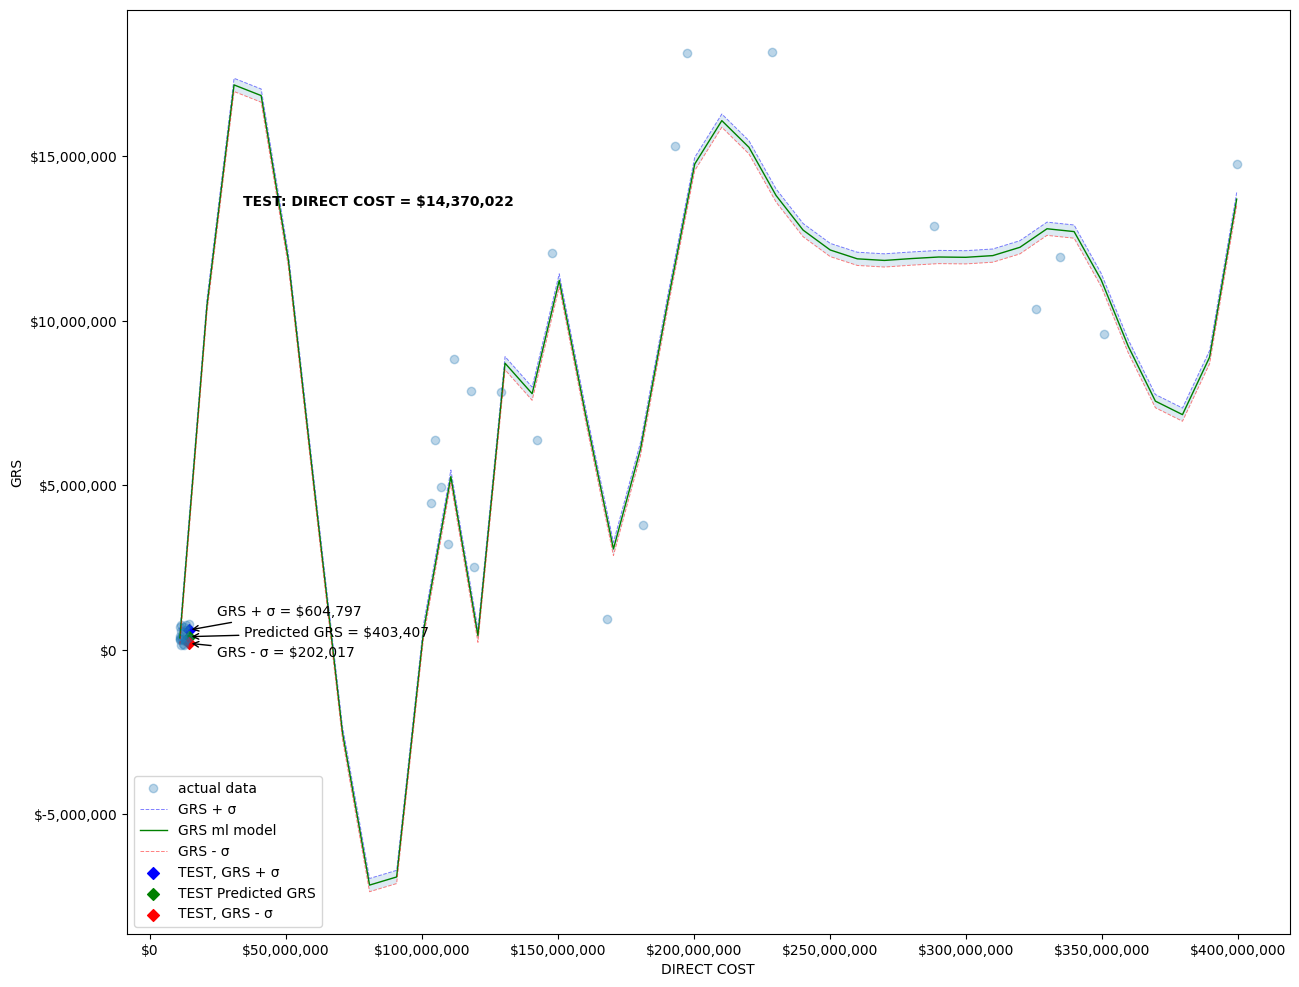

In [6]:
df_use = df
target_name = 'GRS'
job_name = 'TEST'
input_X = np.array([14_370_022, 42_960, 610_265, 181_112, 827_359, 0])
graphWidth = 1500
graphHeight = graphWidth * 800 / 1000

f, details, prediction = ModelAndScatterPlot(df_use, target_name, graphWidth, graphHeight, job_name, input_X)

In [7]:
print(details)

TEST: DIRECT COST = $14,370,022, Predicted GRS: $403,407
RMSE: 201390.04038450867
R-squared: 0.9491295982143335


In [29]:
def altModelAndScatterPlot(df_data, target_name, input_X):

    # set some varibles for use throughout
    graphWidth = 1500
    graphHeight = graphWidth * 800 / 1000
    job_name = input_X[0]
    input_X = input_X[1:]
    feature_name = 'DIRECT COST'
    predictions_name = f'{target_name} PREDICTIONS'
    xData = np.array(df_data['DIRECT_COST'])
    yData = np.array(df_data[f'{target_name}_TRUE'])
    yPred = np.array(df_data[f'{target_name}_PREDICTIONS'])

    absError = yPred - yData
    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(yData))

    # pare down df for vis
    over_val = [_ for _ in df_data.DIRECT_COST.to_list() if _ > input_X[0]]
    over_val = sorted(over_val, reverse=True)
    under_val = [_ for _ in df_data.DIRECT_COST.to_list() if _ < input_X[0]]
    under_val = sorted(under_val, reverse=True)
    val_range = over_val[:15] + under_val[:15]
    df_working = df_data.loc[df_data['DIRECT_COST'].isin(val_range)]
    xData = np.array(df_working['DIRECT_COST'])
    yData = np.array(df_working[f'{target_name}_TRUE'])
    yPred = np.array(df_working[f'{target_name}_PREDICTIONS'])

    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'o', alpha=0.3, label='actual data')

    # now the model as a scatter plot
    axes.scatter(xData, yPred, c='g', marker='*', label=f'{target_name} ml model')

    # now a test value
    try:
        if target_name == 'GRS':
            prediction = grs_model.predict([input_X])
        elif target_name == 'GCS':
            prediction = gcs_model.predict([input_X])
    except ValueError:
        return 'accepted entries are "GRS" or "GCS"'
    j, k = input_X[0], prediction
    plt.text(0.1, 0.8, f'{job_name}: {feature_name} = ${j:,.0f}',ha='left',va='top', weight='bold',transform = axes.transAxes)
    axes.scatter(j, k+RMSE, c='b', marker='D', label=f'{job_name}, {target_name} + σ')
    axes.annotate(f'{target_name} + σ = ${int(prediction)+RMSE:,.0f}', xy=(j, k+RMSE), xytext=(20,10), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))
    axes.scatter(j, k, c='k', marker='D', label=f'{job_name} Predicted {target_name}')
    axes.annotate(f'Predicted {target_name} = ${int(prediction):,.0f}', (j, k), xytext=(40,0), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))
    axes.scatter(j, k-RMSE, c='r', marker='D', label=f'{job_name}, {target_name} - σ')
    axes.annotate(f'{target_name} - σ = ${int(prediction)-RMSE:,.0f}', (j, k-RMSE), xytext=(20,-10), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))

    # labels and stuff
    axes.set_xlabel(feature_name)
    axes.set_ylabel(target_name)
    fmt = '${x:,.0f}'
    tick = StrMethodFormatter(fmt)
    axes.xaxis.set_major_formatter(tick)
    axes.yaxis.set_major_formatter(tick)
    axes.legend(loc='best')

    details = f'{job_name}: {feature_name} = ${input_X[0]:,.0f}, Predicted {target_name}: ${int(prediction):,.0f}\n'+\
                        f'RMSE: {RMSE}\n'+\
                        f'R-squared: {Rsquared}'
    
    return f, details, prediction

c:\Users\SwanS\Anaconda3\envs\grs_fit\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


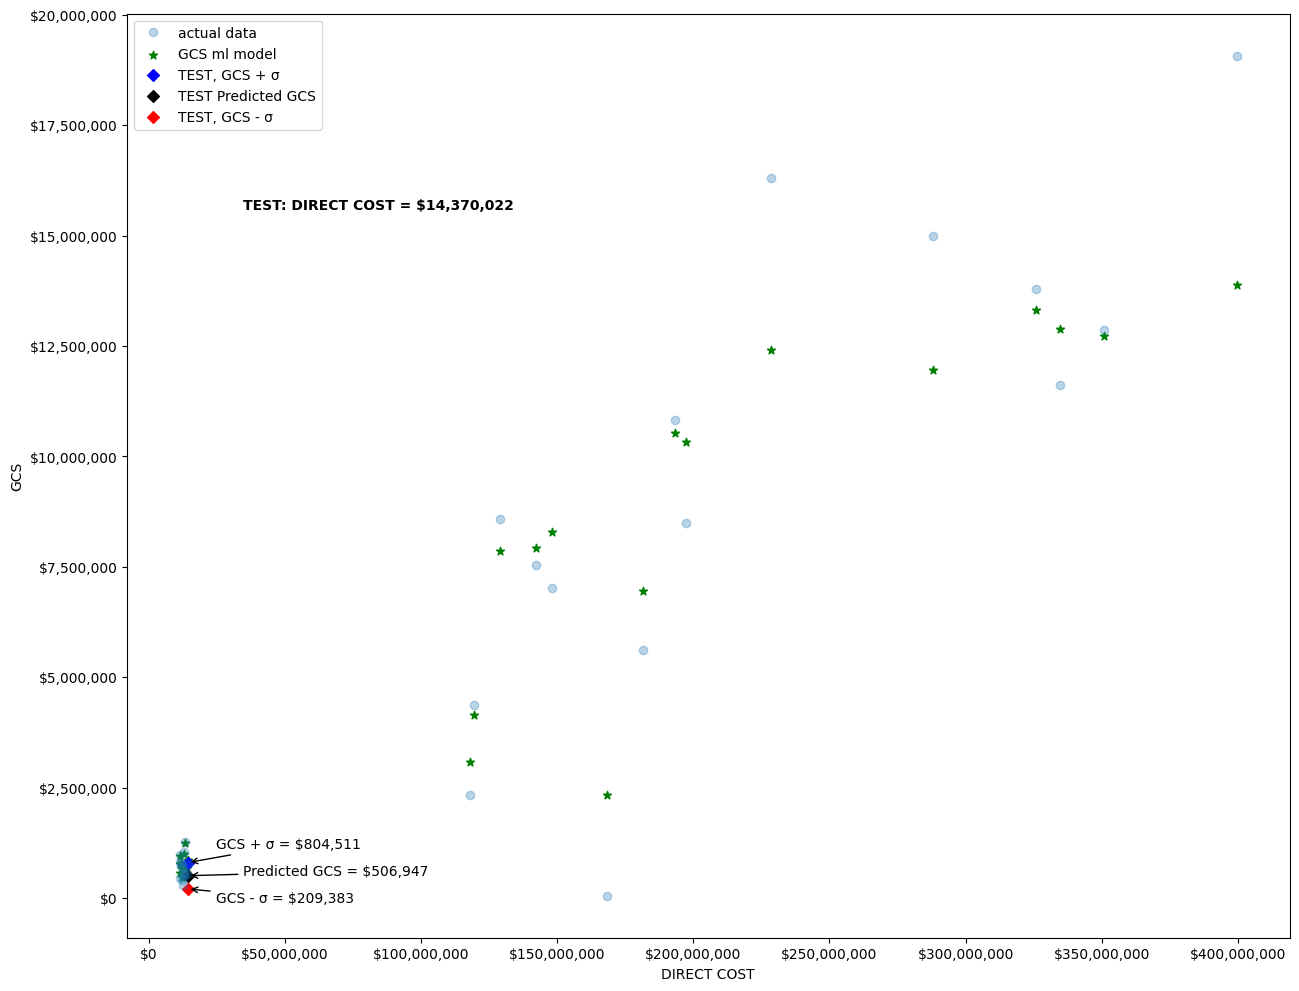

In [32]:
df_use = df
target_name = 'GCS'
# job_name = 'TEST'
input_X = ['TEST', 14_370_022, 42_960, 610_265, 181_112, 827_359, 0]
graphWidth = 1500
graphHeight = graphWidth * 800 / 1000

f, details, prediction = altModelAndScatterPlot(df_use, target_name, graphWidth, graphHeight, input_X)

In [52]:
all_params = sorted(list(set(grs_parameters + gcs_parameters)))

In [63]:
def otherModelAndScatterPlot(df_data, target_name, job_name, input_X):

    # set some varibles for use throughout
    graphWidth = 1500
    graphHeight = graphWidth * 800 / 1000
    job_name = input_X.iloc[0,0]
    input_X = input_X.iloc[0,1:]
    feature_name = 'DIRECT COST'
    predictions_name = f'{target_name} PREDICTIONS'
    xData = np.array(df_data['DIRECT_COST'])
    yData = np.array(df_data[f'{target_name}_TRUE'])
    yPred = np.array(df_data[f'{target_name}_PREDICTIONS'])

    absError = yPred - yData
    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(yData))

    # pare down df for vis
    over_val = [_ for _ in df_data.DIRECT_COST.to_list() if _ > input_X[0]]
    over_val = sorted(over_val, reverse=True)
    under_val = [_ for _ in df_data.DIRECT_COST.to_list() if _ < input_X[0]]
    under_val = sorted(under_val, reverse=True)
    val_range = over_val[:15] + under_val[:15]
    df_working = df_data.loc[df_data['DIRECT_COST'].isin(val_range)]
    xData = np.array(df_working['DIRECT_COST'])
    yData = np.array(df_working[f'{target_name}_TRUE'])
    yPred = np.array(df_working[f'{target_name}_PREDICTIONS'])

    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'o', alpha=0.3, label='actual data')

    # now the model as a scatter plot
    axes.scatter(xData, yPred, c='g', marker='*', label=f'{target_name} ml model')

    # now a test value
    try:
        if target_name == 'GRS':
            prediction = grs_model.predict([input_X])
        elif target_name == 'GCS':
            prediction = gcs_model.predict([input_X])
    except ValueError:
        return 'accepted entries are "GRS" or "GCS"'
    j, k = input_X[0], prediction
    plt.text(0.1, 0.8, f'{job_name}: {feature_name} = ${j:,.0f}',ha='left',va='top', weight='bold',transform = axes.transAxes)
    axes.scatter(j, k+RMSE, c='b', marker='D', label=f'{job_name}, {target_name} + σ')
    axes.annotate(f'{target_name} + σ = ${int(prediction)+RMSE:,.0f}', xy=(j, k+RMSE), xytext=(20,10), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))
    axes.scatter(j, k, c='k', marker='D', label=f'{job_name} Predicted {target_name}')
    axes.annotate(f'Predicted {target_name} = ${int(prediction):,.0f}', (j, k), xytext=(40,0), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))
    axes.scatter(j, k-RMSE, c='r', marker='D', label=f'{job_name}, {target_name} - σ')
    axes.annotate(f'{target_name} - σ = ${int(prediction)-RMSE:,.0f}', (j, k-RMSE), xytext=(20,-10), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))

    # labels and stuff
    axes.set_xlabel(feature_name)
    axes.set_ylabel(target_name)
    fmt = '${x:,.0f}'
    tick = StrMethodFormatter(fmt)
    axes.xaxis.set_major_formatter(tick)
    axes.yaxis.set_major_formatter(tick)
    axes.legend(loc='best')

    details = f'{job_name}: {feature_name} = ${input_X[0]:,.0f}, Predicted {target_name}: ${int(prediction):,.0f}\n'+\
                        f'RMSE: {RMSE}\n'+\
                        f'R-squared: {Rsquared}'
    
    return f, details, prediction

In [67]:
df_use = df
target_name = 'GCS'
edited_df_project_inputs = pd.DataFrame(['TEST', 14_370_022, 42_960, 610_265, 181_112, 827_359, 3_221_653, 173_953, 0], index=['PROJECT_NAME']+all_params).T
edited_gcs_inputs = edited_df_project_inputs[['PROJECT_NAME']+gcs_parameters]
edited_gcs_inputs.drop(['PROJECT_NAME'], axis=1)

,DIRECT_COST,DIV_03_DIRECT_COST,DIV_05_DIRECT_COST,DIV_08_DIRECT_COST,DIV_09_DIRECT_COST,DIV_21_DIRECT_COST
0,14370022,42960,610265,827359,3221653,173953


c:\Users\SwanS\Anaconda3\envs\grs_fit\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


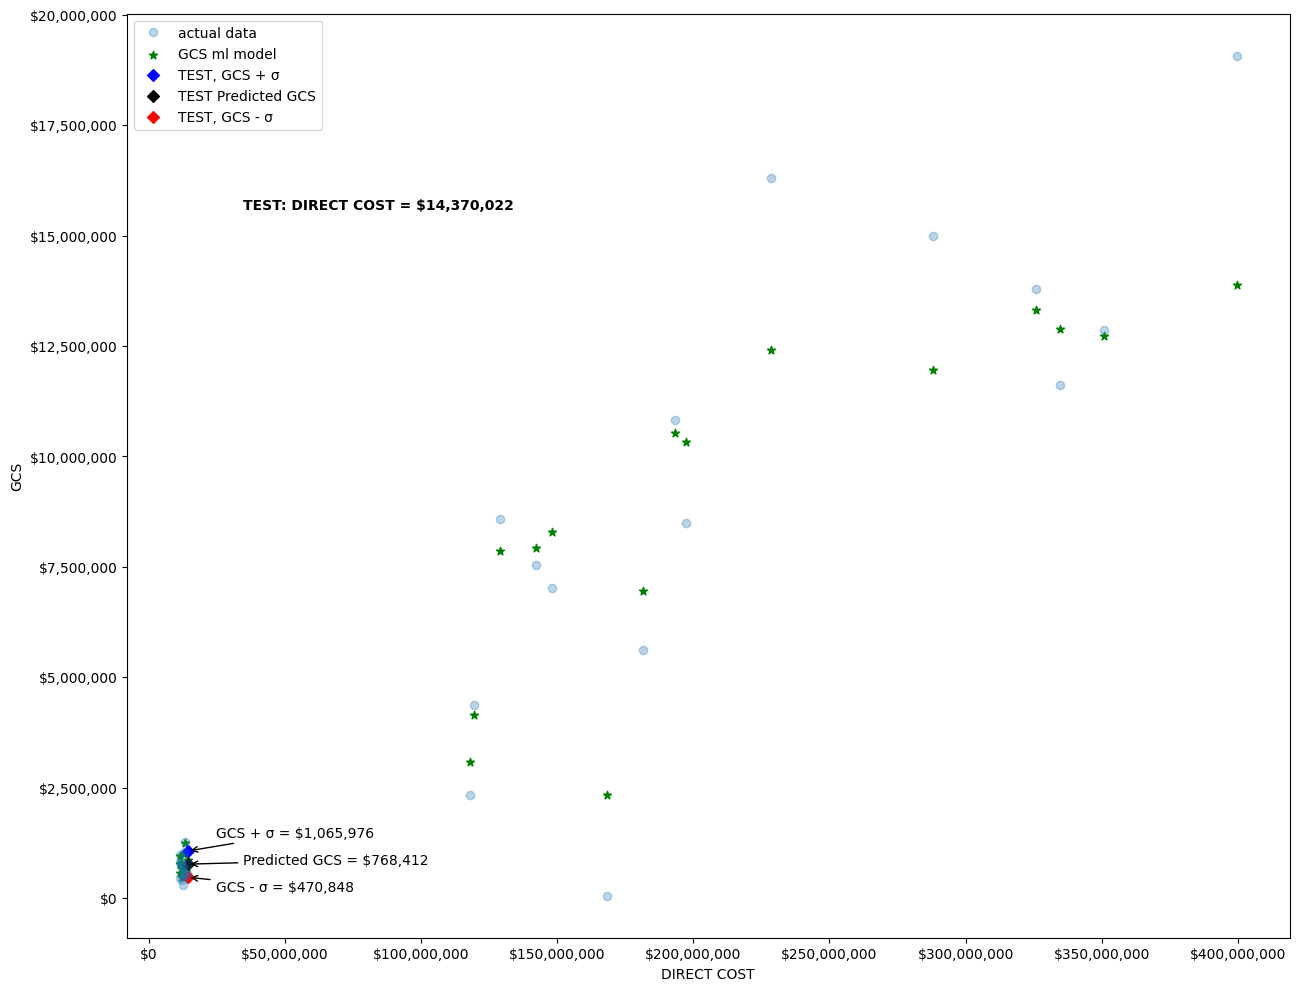

In [66]:
f, details, prediction = otherModelAndScatterPlot(df_use, target_name, job_name, edited_gcs_inputs)

In [79]:
all_params = sorted(list(set(grs_parameters + gcs_parameters)))
placeholder_inputs = ['TEST', 14_370_022, 42_960, 610_265, 181_112, 827_359, 3_221_653, 173_953, 0]
df_project_inputs = pd.DataFrame(placeholder_inputs, index=['_PROJECT_NAME']+all_params).T
int(df_project_inputs['DIRECT_COST'])

14370022

In [ ]:
df.DIRECT_COST.loc[df['DIRECT_COST'] >= int(df_project_inputs['DIRECT_COST'])].to_list()

In [115]:
df_project_inputs['_PROJECT_NAME'].values[0]

'TEST'

In [101]:
dc = df.DIRECT_COST
dc.where(dc > int(df_project_inputs['DIRECT_COST'])).dropna()

JOB
6601     14508527.0
6362     14582662.0
7766     15030128.0
5606     15579409.0
4272     15763168.0
           ...     
7484    288221931.0
6706    325920030.0
6808    334640233.0
5520    350833992.0
7145    399570438.0
Name: DIRECT_COST, Length: 112, dtype: float64

In [97]:
def myfunc(a, b):
    "Return a 3 over and 3 under b"
    if a > b:
        return a

In [98]:
dc = df.DIRECT_COST.values
tgt = int(df_project_inputs['DIRECT_COST'])
vfunc = np.vectorize(myfunc)
vfunc(dc, tgt)

array([None, None, None, ..., 334640233.0, 350833992.0, 399570438.0],
      dtype=object)